In [5]:
import requests
import io
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# List all models
out = requests.get('http://0.0.0.0:8444/models')
print(out.text)

{
  "models": [
    {
      "modelName": "densenet161",
      "modelUrl": "densenet161.mar"
    },
    {
      "modelName": "ssdcnet_sha",
      "modelUrl": "ssdcnet_sha.mar"
    },
    {
      "modelName": "ssdcnet_shb",
      "modelUrl": "ssdcnet_shb.mar"
    }
  ]
}



In [3]:
# Take a sample picture
img_path1 = '/home/ubuntu/CrowdSourcing_Projects/CSRNet-keras/data/Classify_all/sparse/IMG_7.jpg'
img_path2 = '/home/ubuntu/CrowdSourcing_Projects/CSRNet-keras/data/Classify_all/dense/20.jpg'
image1 = Image.open(img_path1).convert('RGB')
image2 = Image.open(img_path2).convert('RGB')

In [6]:
print(type(image1))
output = io.BytesIO()
image1.save(output, format='JPEG')
hex_data = output.getvalue()
print(type(hex_data))
print(hex_data)

<class 'PIL.Image.Image'>
<class 'bytes'>
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x03\x00\x04\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc

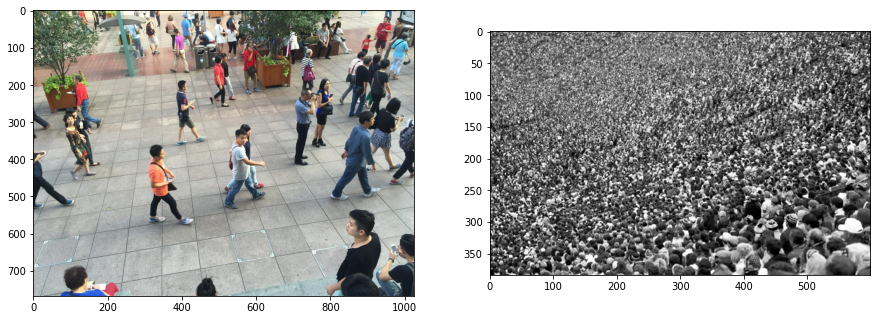

In [38]:
# Show images
rcParams['figure.figsize'] = 15 ,15
fig, ax = plt.subplots(1,2)
ax[0].imshow(image1);
ax[1].imshow(image2);
# plt.imshow(image1)
# plt.imshow(image2)

In [7]:
# Read as binary data
data1 = open(img_path1,'rb').read()
data2 = open(img_path2,'rb').read()

In [8]:
print(type(data1))
print(type(data2))

<class 'bytes'>
<class 'bytes'>


In [12]:
dense_url = 'http://0.0.0.0:8443/predictions/ssdcnet_sha'
r12 = requests.post(dense_url,data=hex_data)
r13 = requests.post(dense_url,data=data1)
print(r12.text)
print(r13.text)

46
46


In [34]:
# Torchserve Inference API's
dense_url = 'http://0.0.0.0:8443/predictions/ssdcnet_sha'
sparse_url = 'http://0.0.0.0:8443/predictions/ssdcnet_shb'
r1_s = requests.post(sparse_url,data=data1)
r1_d = requests.post(dense_url,data=data1)

r2_d = requests.post(dense_url,data=data2)
r2_s = requests.post(sparse_url,data=data2)

print(r1_d.status_code)
print(r1_s.status_code)
print(r2_d.status_code)
print(r2_s.status_code)

200
200
200
200


In [39]:
print("Counts for Image1 -  TorchServe Sparse Model: {}    Dense Model: {}".format(r1_s.text,r1_d.text))
print("Counts for Image2 -   TorchServe Sparse Model: {}    Dense Model: {}".format(r2_s.text,r2_d.text))

Counts for Image1 -  TorchServe Sparse Model: 49    Dense Model: 46
Counts for Image2 -   TorchServe Sparse Model: 572    Dense Model: 3123


### CSRNet TF Model

In [44]:
from tensorflow.core.framework import types_pb2
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import grpc

ModuleNotFoundError: No module named 'tensorflow_serving'

In [40]:
def prepare_image(img, im_type=None):
    if im_type=="classify":
        newsize = (224, 224) 
        img = img.resize(newsize) 
    #Function to load,normalize and return image 
    im = np.array(img)
    im = im/255.0
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225
    im = np.expand_dims(im,axis  = 0)
    # print(str(im.shape()))
    return im

In [41]:
def create_tf_prediction_request():
    channel = grpc.insecure_channel("127.0.0.1:8500")
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    return stub,request

In [42]:
st, req = create_tf_prediction_request()
image = prepare_image(data1)

req.model_spec.name = "sparse_crowd"
req.inputs["input_image"].CopyFrom(tf.make_tensor_proto(image, dtype=types_pb2.DT_FLOAT))
data = {"success": False}
response = st.Predict(req, timeout=60.0)
p_hmap = tf.make_ndarray(response.outputs['y_out/Relu:0'])
count = np.sum(p_hmap)
print(str(round(count)))

NameError: name 'grpc' is not defined